# Exploratory Data Analysis

In [6]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
import yaml

from pandas_profiling import ProfileReport
from pyspark.sql import SparkSession

while not Path("data") in Path(".").iterdir():
    os.chdir("..")

plt.style.use("seaborn-white")
conf_dict = yaml.safe_load(Path("config/conf.yaml").read_text())

graphframes_jar_path = str(
    Path("jars/graphframes-0.8.2-spark3.1-s_2.12.jar").absolute()
)

spark = (
    SparkSession.builder.config("spark.driver.memory", "8g")
    .config(
        "spark.jars",
        graphframes_jar_path,
    )
    .getOrCreate()
)

In [2]:
companies_processed_df = spark.read.parquet(conf_dict["companies_processed"])
relationships_processed_df = spark.read.parquet(conf_dict["relationships_processed"])
persons_processed_df = spark.read.parquet(conf_dict["persons_processed"])
addresses_processed_df = spark.read.parquet(conf_dict["addresses_processed"])

In [3]:
all_dfs_dict = {
    "companies": companies_processed_df,
    "relationships": relationships_processed_df,
    "persons": persons_processed_df,
    "addresses": addresses_processed_df,
}

In [4]:
for key, df in all_dfs_dict.items():
    print(key)
    print("-" * 79)
    print(f"{df.count():,}")
    df.printSchema()
    print()

companies
-------------------------------------------------------------------------------
7,246,475
root
 |-- statementID: string (nullable = true)
 |-- name: string (nullable = true)
 |-- foundingDate: string (nullable = true)
 |-- dissolutionDate: string (nullable = true)
 |-- countryCode: string (nullable = true)
 |-- companiesHouseID: string (nullable = true)
 |-- openCorporatesID: string (nullable = true)
 |-- openOwnershipRegisterID: string (nullable = true)
 |-- CompanyCategory: string (nullable = true)
 |-- CompanyStatus: string (nullable = true)
 |-- Accounts_AccountCategory: string (nullable = true)
 |-- SICCode_SicText_1: string (nullable = true)


relationships
-------------------------------------------------------------------------------
5,704,926
root
 |-- interestedPartyStatementID: string (nullable = true)
 |-- interestedPartyIsPerson: boolean (nullable = true)
 |-- subjectStatementID: string (nullable = true)
 |-- minimumShare: double (nullable = true)


persons
-----

## Profiles

In [5]:
all_pd_dict = {}

for name, df in all_dfs_dict.items():
    path = f"notebooks/{name}.html"
    df_pd: pd.DataFrame = df.sample(0.001).toPandas().sample(1_000)  # type: ignore
    all_pd_dict[name] = df_pd
    if not Path(path).exists():
        profile = ProfileReport(df_pd)
        profile.to_file(path)
    else:
        print(f"file exists: {path}; profiling skipped...")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Missing Values

In [12]:
def plot_missing(df):
    nulls = df.isna().to_numpy(dtype=int).T
    plt.imshow(nulls, aspect="auto", interpolation="none")
    plt.yticks(ticks=range(df.shape[1]), labels=df.columns)
    plt.show()

companies
-------------------------------------------------------------------------------


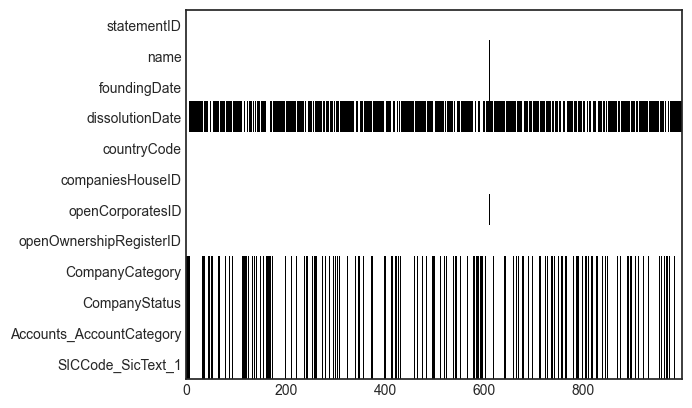



relationships
-------------------------------------------------------------------------------


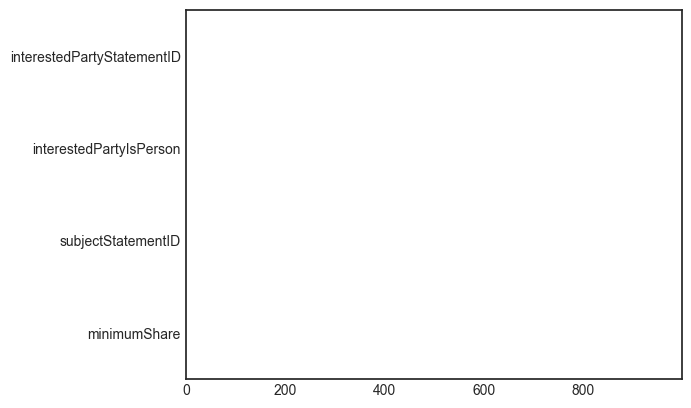



persons
-------------------------------------------------------------------------------


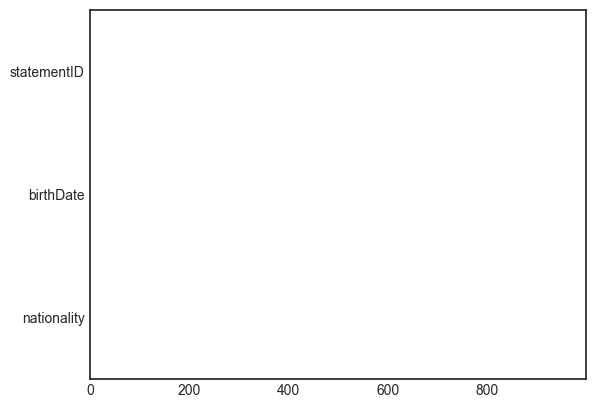



addresses
-------------------------------------------------------------------------------


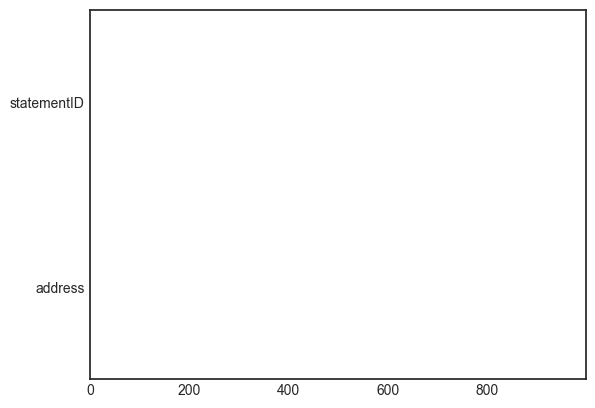

In [13]:
for name, df in all_pd_dict.items():
    print(name)
    print("-" * 79)
    plot_missing(df)
    print()
    print()

## Companies

Quite a few companies are missing information from Companies House. Further investigation through Companies House suggests these are largely dissolved or dormant companies.

In [16]:
grouping = (
    F.col("CompaniesHouseID").isNotNull().alias("hasChID"),
    F.col("SICCode_SicText_1").isNull().alias("hasSicCode"),
    F.col("CompanyStatus").contains("Active").alias("active"),
)
companies_processed_df.groupBy(*grouping).count().orderBy(*grouping).show()

+-------+----------+------+-------+
|hasChID|hasSicCode|active|  count|
+-------+----------+------+-------+
|  false|      true|  null|    717|
|   true|     false| false|  70316|
|   true|     false|  true|4784668|
|   true|      true|  null|2390772|
|   true|      true| false|      2|
+-------+----------+------+-------+



In [21]:
activity_null = (
    companies_processed_df.filter(
        (F.col("SICCode_SicText_1").isNull())
        & (F.col("CompaniesHouseID").isNotNull())
        & (F.col("CompanyStatus").isNull())
    )
    .limit(10)
    .toPandas()
)
for row in list(activity_null.itertuples())[:5]:
    print(row)
    print()

Pandas(Index=0, statementID='7094100818963926915', name='KAY AND COMPANY LIMITED', foundingDate='1895-06-08', dissolutionDate='2019-11-12', countryCode='GB', companiesHouseID='00044307', openCorporatesID='https://opencorporates.com/companies/gb/00044307', openOwnershipRegisterID='http://register.openownership.org/entities/59b9767567e4ebf3407917fb', CompanyCategory=None, CompanyStatus=None, Accounts_AccountCategory=None, SICCode_SicText_1=None)

Pandas(Index=1, statementID='7633360340268313763', name='KEMP & HEWITT LIMITED', foundingDate='1896-08-15', dissolutionDate='2017-12-05', countryCode='GB', companiesHouseID='00049147', openCorporatesID='https://opencorporates.com/companies/gb/00049147', openOwnershipRegisterID='http://register.openownership.org/entities/59c4f08567e4ebf3403e60df', CompanyCategory=None, CompanyStatus=None, Accounts_AccountCategory=None, SICCode_SicText_1=None)

Pandas(Index=2, statementID='7082278104334791553', name='THE FORMER RIBBLE MOTOR SERVICES LIMITED', foun

In [22]:
no_ch_id = (
    companies_processed_df.filter((F.col("CompaniesHouseID").isNull()))
    .limit(10)
    .toPandas()
)
for row in list(no_ch_id.itertuples())[:5]:
    print(row)
    print()

Pandas(Index=0, statementID='11405100442221021143', name='ABSOLUTE PROPERTY SERVICES GROUP LIMITED', foundingDate='2007-05-14', dissolutionDate='2019-10-10', countryCode='GB', companiesHouseID=None, openCorporatesID='https://opencorporates.com/companies/gb/06246269', openOwnershipRegisterID='http://register.openownership.org/entities/59b99e0e67e4ebf3401982ad', CompanyCategory=None, CompanyStatus=None, Accounts_AccountCategory=None, SICCode_SicText_1=None)

Pandas(Index=1, statementID='14922368780388914193', name='ST GEORGE BAPTIST CHURCH', foundingDate=None, dissolutionDate=None, countryCode='GB', companiesHouseID=None, openCorporatesID='https://opencorporates.com/companies/gb/CE013574', openOwnershipRegisterID='http://register.openownership.org/entities/5b16b3789dfc3fae18128a97', CompanyCategory=None, CompanyStatus=None, Accounts_AccountCategory=None, SICCode_SicText_1=None)

Pandas(Index=2, statementID='15291571826813258519', name='Gillian Smith', foundingDate='2007-02-15', dissoluti